In [1]:
import numpy as np
import pandas as pd
from GENIE3 import *
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Ranking of feature importance for genes.

In [2]:
allImp = np.load("NormalizedImp100.npy")
gene = np.load('../../data/geneAfterDiscard_0.npy', allow_pickle=True)

impSum = allImp.sum(axis = 0)

geneIdx = [i for i in range(gene.shape[0])]

toSort = zip(geneIdx, impSum)
sortedImp = sorted(toSort, key=lambda x: x[1], reverse=1)

sortedImp = np.array(list(zip(*sortedImp)))

sortedIdx = sortedImp[0].astype(int)
print(sortedIdx.shape)
print(sortedIdx)

(11959,)
[ 3774  1667  2429 ... 11944 11947 11951]


In [3]:
data = np.load('../../data/oversampled_data.npy', allow_pickle=True)

feature = data[:, :-1]
label = data[:, -1]
print(gene.shape)
print(feature.shape)
print(label.shape)

(11959,)
(296, 11959)
(296,)


# Select the satisfactory gene.

In [4]:
ISGnum = 60

ISGidx = sortedIdx[:ISGnum]

ISGfeature = feature[:, ISGidx]
ISGgene_np = gene[ISGidx]
ISGgene_list = ISGgene_np.tolist()


# Gaussian normalization and GENIE3

In [5]:
mean = ISGfeature.mean(axis = 0)
std = ISGfeature.std(axis = 0)
ISGfeature = ISGfeature - mean
ISGfeature = ISGfeature / std


# # Genes that are used as candidate regulators
# regulators = ['CD19', 'CDH17','RAD51','OSR2','TBX3']
# VIM2 = GENIE3(data,gene_names=gene_names,regulators=regulators)

VIM = GENIE3(ISGfeature, nthreads = 8) #data,tree_method=tree_method,K=K,ntrees=ntrees, 

get_link_list(VIM, gene_names=ISGgene_list, file_name='ranking.txt') # regulators=regulators,

In [6]:
relation_rank = pd.read_csv("ranking.txt", sep = "\t", header = None)
relation_rank

,0,1,2
0,RAB10,HPGD,0.135707
1,PDCD6IP,OXSR1,0.120451
2,NOL7,TMEM14C,0.118211
3,OXSR1,PDCD6IP,0.115552
4,NAAA,HPGD,0.114883
...,...,...,...
3535,RILPL1,NOL7,0.004142
3536,HDAC1,HPGD,0.004137
3537,TBC1D22A,ASNSD1,0.004132
3538,MC1R,ASB14,0.003936


# Calculate the regulatory importance of genes.

In [7]:
weight = [0 for i in range(ISGnum)]

for i in relation_rank.index:
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 0])[0][0]] += relation_rank.iloc[i, 2]
    weight[np.argwhere(ISGgene_np == relation_rank.iloc[i, 1])[0][0]] += relation_rank.iloc[i, 2]

weight = np.array(weight)
weight

array([2.223949, 2.150546, 1.780223, 1.986548, 2.455564, 1.677764,
       2.332503, 2.302123, 1.950081, 1.912701, 1.92551 , 1.670871,
       2.018506, 1.899842, 1.815287, 1.878813, 1.92477 , 1.795787,
       2.110479, 1.976269, 1.963155, 2.407566, 1.831467, 2.178636,
       1.991641, 2.20879 , 1.98367 , 2.180366, 2.042445, 1.847249,
       1.952514, 1.864291, 2.105742, 2.014947, 1.739645, 1.925029,
       2.094914, 1.901425, 1.933126, 2.044465, 1.904675, 1.873102,
       1.893333, 1.737946, 1.947994, 2.010334, 1.731554, 1.960711,
       1.858147, 2.190894, 1.785902, 1.85073 , 1.832379, 2.239532,
       2.303298, 1.827779, 2.431726, 2.081033, 2.068249, 1.840741])

# Genes are sorted in ascending order according to regulatory importance.

In [8]:
order_idx = np.argsort(weight)

order_gene = ISGgene_np[order_idx]
np.savetxt('genie3_order_gene.txt', np.c_[order_gene], fmt='%s',delimiter='\t')
order_gene

array(['TCTA', 'ALOX15B', 'TBC1D22A', 'ABCD1', 'ADRM1', 'DALRD3',
       'BEGAIN', 'CYSLTR2', 'IRF5', 'PSMC2', 'WDR27', 'H19', 'NAAA',
       'TCF7L2', 'PPRC1', 'HMGN5', 'ME3', 'SLC4A1AP', 'PBX2', 'COQ10B',
       'MPP5', 'BAD', 'PIP4K2B', 'UPRT', 'PC', 'HERPUD2', 'HDAC1',
       'SGPP2', 'DENND3', 'MC1R', 'HEBP2', 'PLA2G16', 'OXSR1', 'USP33',
       'STK25', 'C2orf49', 'NGLY1', 'GET4', 'GCNT2', 'HPGD', 'MARCH7',
       'SLC25A20', 'TMEM14C', 'ASNSD1', 'TMEM223', 'MFSD3', 'PDCD6IP',
       'CDC16', 'PRKCQ', 'ASB14', 'RILPL1', 'TRIM39', 'GARS', 'GLUL',
       'SLC35A1', 'RAB10', 'PPT2', 'MAP4', 'ARHGEF11', 'NOL7'],
      dtype=object)

In [9]:
feature_after_GENIE3 = ISGfeature[:, order_idx] # final_gene_num
feature_after_GENIE3.shape

(296, 60)

# Run the feature elimination algorithm.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [12]:
reserved_gene_idx = []
alternative_gene_idx = [i for i in range(order_gene.shape[0])]

init_acc = 0

geneNum = []
acc = []
prec = []
rec = []
auc = []

times = order_gene.shape[0]

# train-test split    random_state=2022
X_train, X_test, y_train, y_test = train_test_split(feature_after_GENIE3, label, test_size=0.3, shuffle=True, random_state=2022)

for i in range(times):
    
    geneNum.append(i + 1)
    reserved_gene_idx += [alternative_gene_idx[i]]
    
    xTrain = X_train[:, np.array(reserved_gene_idx)]
    xTest = X_test[:, np.array(reserved_gene_idx)]

    allAcc = []
    allPrec = []
    allRec = []
    allAuc = []
    
    for _ in range(5):
        rf = RandomForestClassifier()
        rf.fit(xTrain, y_train)  
        y_pred = rf.predict(xTest)
        
        allAcc.append(accuracy_score(y_test, y_pred))
        allPrec.append(precision_score(y_test, y_pred))
        allRec.append(recall_score(y_test, y_pred))
        predict_prob_y = rf.predict_proba(xTest)[:, 1]
        allAuc.append(roc_auc_score(y_test, predict_prob_y))

    if np.array(allAcc).mean() > init_acc:
        init_acc = np.array(allAcc).mean()
        
        acc.append(np.array(allAcc).mean())
        prec.append(np.array(allPrec).mean())
        rec.append(np.array(allRec).mean())
        auc.append(np.array(allAuc).mean())
    else:
        reserved_gene_idx.remove(alternative_gene_idx[i])
        
        
geneNum = np.array(geneNum)
acc = np.array(acc)
prec = np.array(prec)
rec = np.array(rec)
auc = np.array(auc)

feature_elimination_path = "performance/feature_elimination_genie3_asc_"

np.save(feature_elimination_path + "acc.npy", acc)
np.save(feature_elimination_path + "prec.npy", prec)
np.save(feature_elimination_path + "rec.npy", rec)
np.save(feature_elimination_path + "auc.npy", auc)

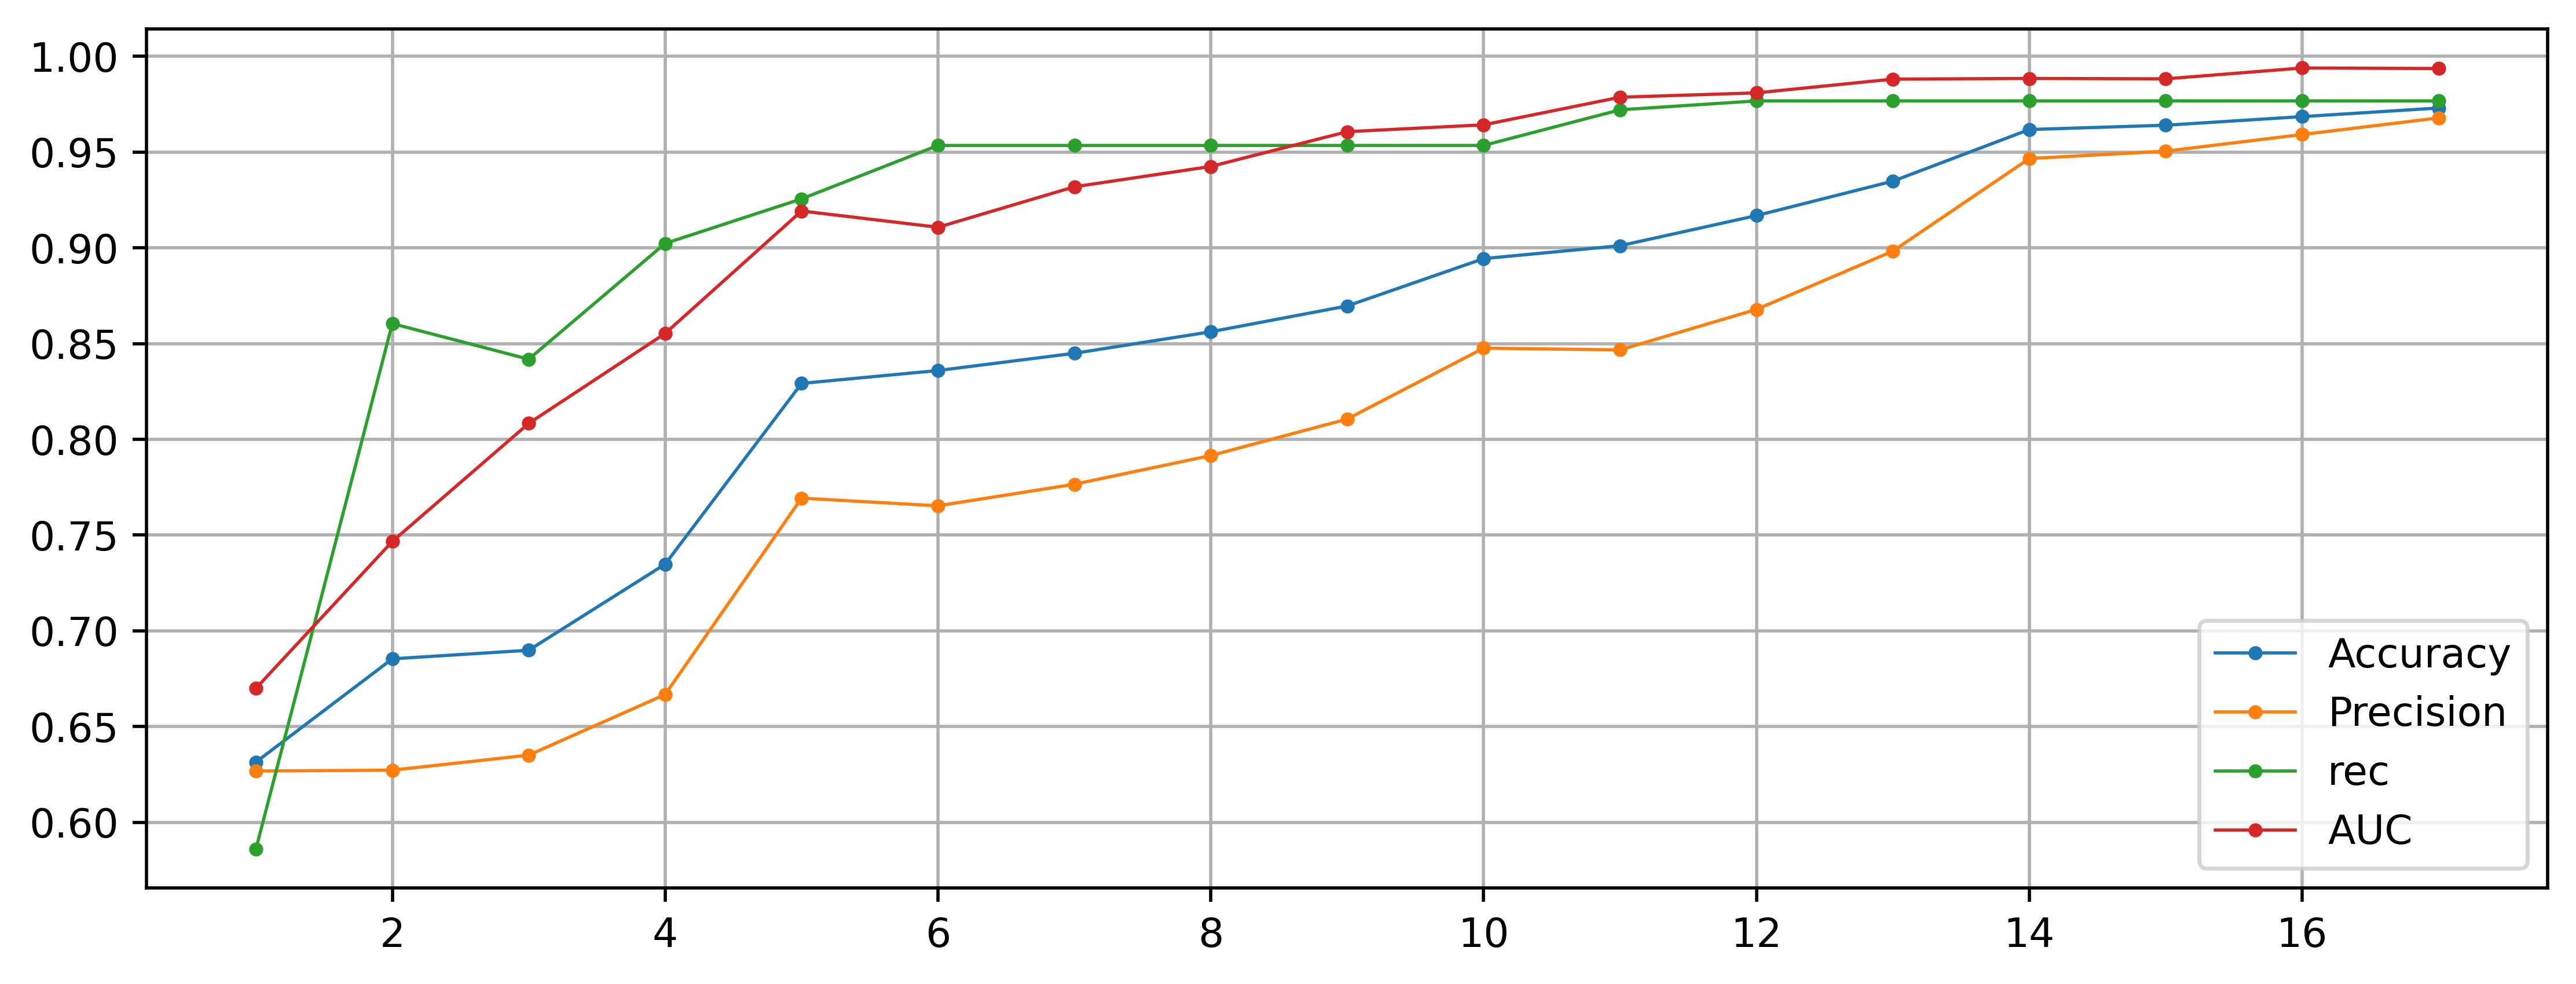

In [14]:
ISGnum = bar = len(acc)

pointnum = bar
x_axi = geneNum[:pointnum]
plt.figure(figsize=(9, 3.5), dpi=500)

markersize = 5
linewidth = 0.8

plt.plot(x_axi, acc[:pointnum], '.-',label='Accuracy', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, prec[:pointnum], '.-',label='Precision', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, rec[:pointnum], '.-',label='rec', markersize= markersize, linewidth = linewidth)
plt.plot(x_axi, auc[:pointnum], '.-',label='AUC', markersize= markersize, linewidth = linewidth)

plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()

In [16]:
checkPoint = ISGnum - 1
print('{}\t{}\t{}\t{}\t{}'.format(ISGnum, acc[checkPoint], prec[checkPoint], rec[checkPoint],  auc[checkPoint]))

17	0.9730337078651686	0.9678646934460888	0.9767441860465116	0.993680485338726
